<a href="https://colab.research.google.com/github/Samjacob007/Advanced-Brain-Tumor-Diagnosis-with-CNNs-A-Multi-Task-Learning-Approach-for-MRI-Image-Classificatio/blob/main/brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import datetime
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import cv2
import os
import io
import random
from collections import Counter
from sklearn.utils import class_weight
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
!pip install imblearn
from imblearn.over_sampling import SMOTE
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight

# Mount Google Drive
drive.mount('/content/drive')

# Define the project path without spaces in the mount point
base_path = '/content/drive/MyDrive/project/brain tumor'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 5.6 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:


# Labels and image size
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
image_size = 224  # Resize all images to 224x224
sample_size = 500  # Number of samples per class

# Initialize empty lists for data
x_train = []
y_train_classification = []
x_test = []
y_test_classification = []

base_path = '/content/drive/MyDrive/project/brain tumor'

# Function to load and sample random images
def load_and_sample_images(base_path, subset, sample_size):
    data, labels_list = [], []
    for label_idx, label in enumerate(labels):
        subset_path = os.path.join(base_path, subset, label)
        all_files = os.listdir(subset_path)
        sampled_files = random.sample(all_files, min(len(all_files), sample_size))  # Randomly sample
        for file in tqdm(sampled_files, desc=f"Processing {subset} - {label}"):
            image = cv2.imread(os.path.join(subset_path, file))
            image = cv2.resize(image, (image_size, image_size))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
            data.append(image)
            labels_list.append(label_idx)
    return np.array(data), np.array(labels_list)

# Load training data
x_train, y_train_classification = load_and_sample_images(base_path, 'Training', sample_size)

# Load testing data
x_test, y_test_classification = load_and_sample_images(base_path, 'Testing', sample_size)

# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

# One-hot encode labels
y_train_classification = to_categorical(y_train_classification, num_classes=len(labels))
y_test_classification = to_categorical(y_test_classification, num_classes=len(labels))

# Verify data shapes
print(f"x_train shape: {x_train.shape}")
print(f"y_train_classification shape: {y_train_classification.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test_classification shape: {y_test_classification.shape}")

# Verify class distribution
print("Training class distribution:", Counter(np.argmax(y_train_classification, axis=1)))
print("Testing class distribution:", Counter(np.argmax(y_test_classification, axis=1)))

Processing Testing - pituitary: 100%|██████████| 300/300 [00:03<00:00, 88.70it/s] 


x_train shape: (2000, 224, 224, 3)
y_train_classification shape: (2000, 4)
x_test shape: (1311, 224, 224, 3)
y_test_classification shape: (1311, 4)
Training class distribution: Counter({0: 500, 1: 500, 2: 500, 3: 500})
Testing class distribution: Counter({2: 405, 1: 306, 0: 300, 3: 300})


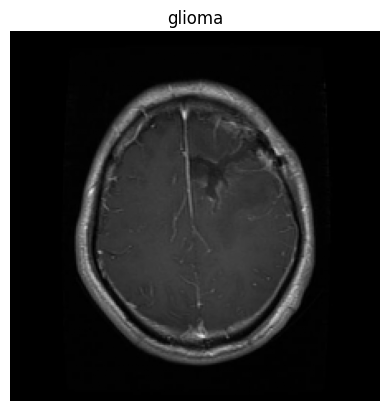

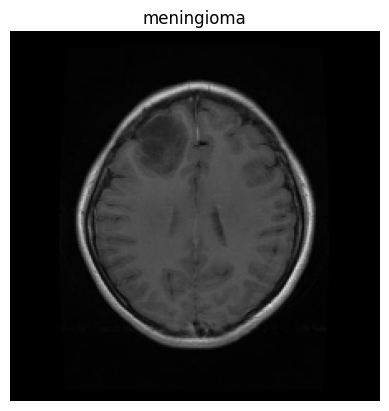

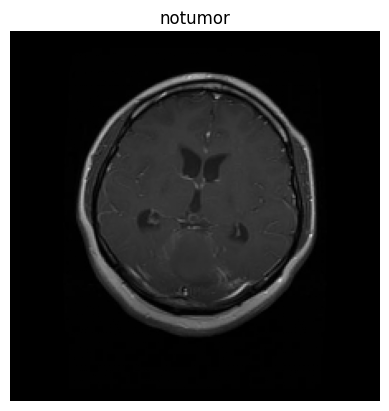

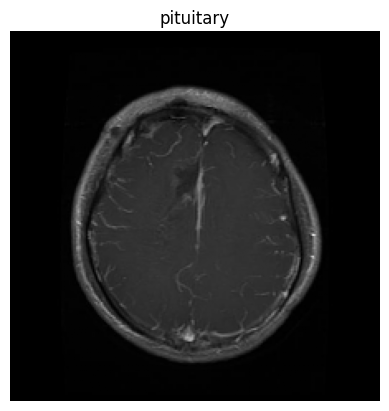

In [3]:

# Display the first image for each class
for i in range(4):
    plt.imshow(x_train[i])  # Assuming your data is ordered by class
    plt.title(labels[i])  # Display class name
    plt.axis('off')
    plt.show()

In [4]:

# Shuffle data and labels
x_train, y_train_classification = shuffle(x_train, y_train_classification, random_state=42)

In [5]:
from sklearn.model_selection import train_test_split

# Split the training data into training and validation sets
x_train_final, x_val, y_train_final, y_val = train_test_split(
    x_train, y_train_classification, test_size=0.2, random_state=42
)

# Check the shapes of the splits
print(f"x_train_final shape: {x_train_final.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train_final shape: {y_train_final.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test_classification shape: {y_test_classification.shape}")


x_train_final shape: (1600, 224, 224, 3)
x_val shape: (400, 224, 224, 3)
x_test shape: (1311, 224, 224, 3)
y_train_final shape: (1600, 4)
y_val shape: (400, 4)
y_test_classification shape: (1311, 4)


In [6]:
# Function to count class distribution
def count_class_distribution(y_data):
    # If one-hot encoded, sum across axis 0 to count each class
    if len(y_data.shape) == 2 and y_data.shape[1] > 1:
        return np.sum(y_data, axis=0)
    # Otherwise, use bincount for single-label arrays
    return np.bincount(y_data)

# Check class distribution in each split
train_class_counts = count_class_distribution(y_train_final)
val_class_counts = count_class_distribution(y_val)
test_class_counts = count_class_distribution(y_test_classification)

# Print the class distribution
print("Training class distribution:", train_class_counts)
print("Validation class distribution:", val_class_counts)

Training class distribution: [394. 409. 393. 404.]
Validation class distribution: [106.  91. 107.  96.]


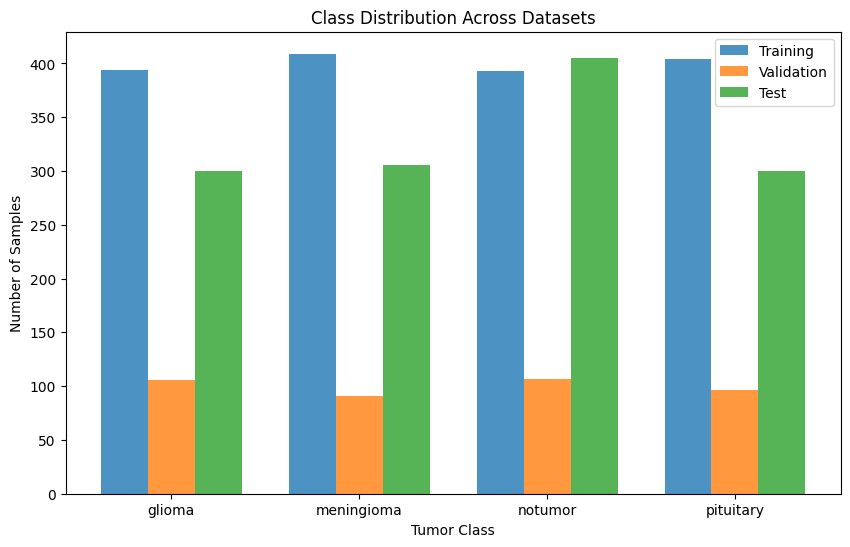

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Sum one-hot encoded labels to get class counts
train_class_counts = np.sum(y_train_final, axis=0)
val_class_counts = np.sum(y_val, axis=0)
test_class_counts = np.sum(y_test_classification, axis=0)

# Class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Plot bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.25
x_indexes = np.arange(len(class_names))

plt.bar(x_indexes, train_class_counts, width=bar_width, label='Training', alpha=0.8)
plt.bar(x_indexes + bar_width, val_class_counts, width=bar_width, label='Validation', alpha=0.8)
plt.bar(x_indexes + 2 * bar_width, test_class_counts, width=bar_width, label='Test', alpha=0.8)

plt.xticks(x_indexes + bar_width, class_names)
plt.title("Class Distribution Across Datasets")
plt.xlabel("Tumor Class")
plt.ylabel("Number of Samples")
plt.legend()
plt.show()

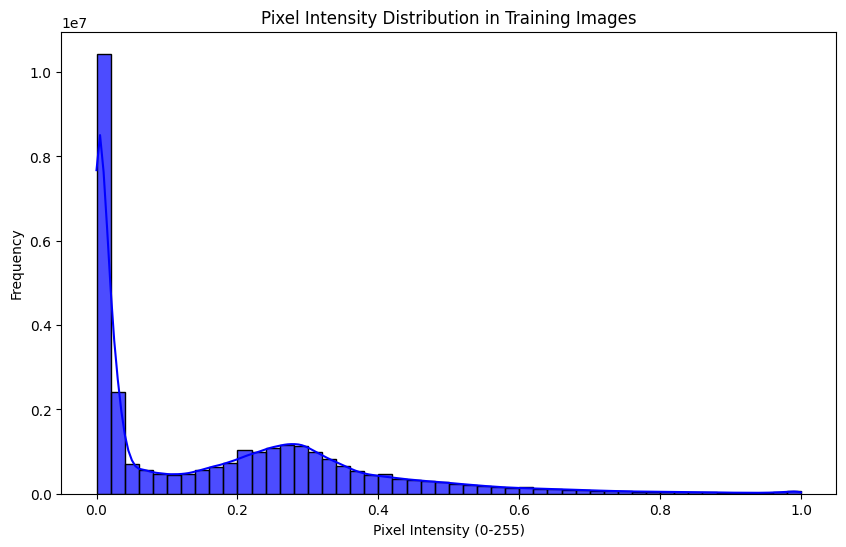

In [8]:
import seaborn as sns

# Flatten pixel values of a random sample from the training set
random_sample = x_train_final[:200]  # Use 200 random images
flattened_pixels = random_sample.reshape(-1)

# Plot histogram of pixel intensities
plt.figure(figsize=(10, 6))
sns.histplot(flattened_pixels, bins=50, kde=True, color='blue', alpha=0.7)
plt.title("Pixel Intensity Distribution in Training Images")
plt.xlabel("Pixel Intensity (0-255)")
plt.ylabel("Frequency")
plt.show()


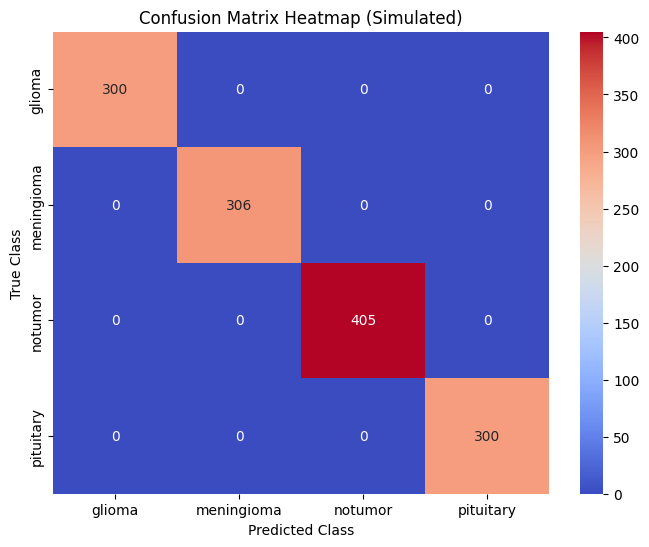

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Simulate predictions (replace with actual predictions if available)
y_pred_simulated = np.argmax(y_test_classification, axis=1)  # Simulated ground truth

# Compute confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test_classification, axis=1), y_pred_simulated)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix Heatmap (Simulated)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

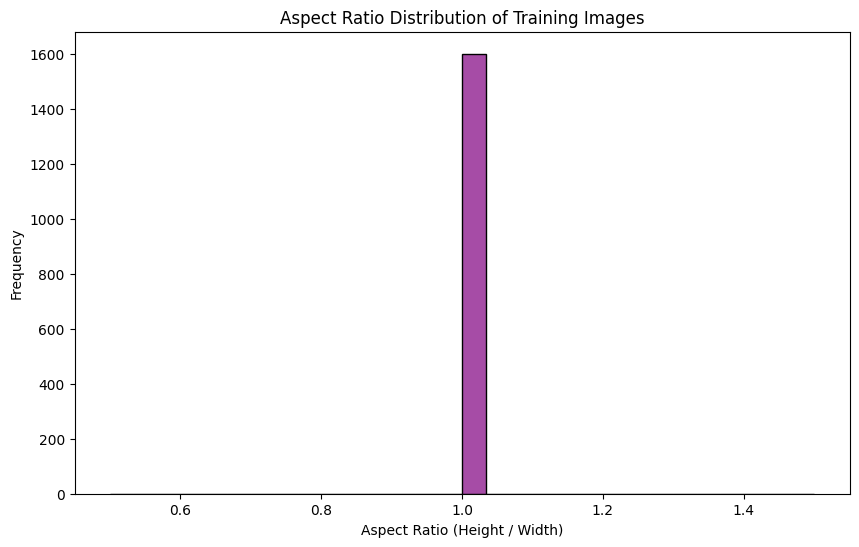

In [9]:
# Extract original image dimensions before resizing
heights = [img.shape[0] for img in x_train_final]
widths = [img.shape[1] for img in x_train_final]

# Calculate aspect ratios
aspect_ratios = np.array(heights) / np.array(widths)

# Plot histogram of aspect ratios
plt.figure(figsize=(10, 6))
sns.histplot(aspect_ratios, bins=30, kde=True, color='purple', alpha=0.7)
plt.title("Aspect Ratio Distribution of Training Images")
plt.xlabel("Aspect Ratio (Height / Width)")
plt.ylabel("Frequency")
plt.show()

In [10]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


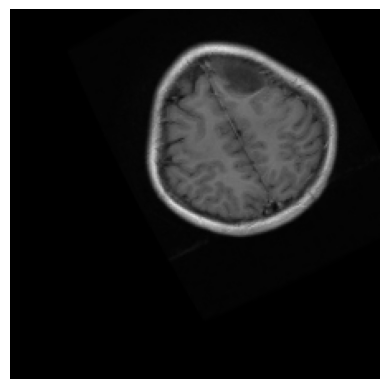

In [11]:
# Apply data augmentation on the training set
datagen.fit(x_train_final)

# Visualize Augmented Images
for x_batch, y_batch in datagen.flow(x_train_final, y_train_final, batch_size=4):
    for i in range(4):
        plt.imshow(x_batch[i])
        plt.axis('off')
    plt.show()
    break

In [12]:
# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_final.argmax(axis=1)),
    y=y_train_final.argmax(axis=1)
)
class_weights = dict(enumerate(class_weights))

In [13]:
# Load Pre-Trained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-Tune Last Few Layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Add Custom Layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)  # 4 classes: glioma, meningioma, notumor, pituitary

# Define Model
vgg_model = Model(inputs=base_model.input, outputs=output)

# Compile Model
vgg_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
# Define Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_vgg16_model.keras', monitor='val_loss', save_best_only=True)
]

In [15]:
# Train Model
history_vgg = vgg_model.fit(
    datagen.flow(x_train_final, y_train_final, batch_size=32),
    validation_data=(x_val, y_val),
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/30
50/50 [==============================] - 109s 2s/step - loss: 4.8736 - accuracy: 0.5300 - precision: 0.6789 - recall: 0.3581 - val_loss: 3.3760 - val_accuracy: 0.7475 - val_precision: 0.8028 - val_recall: 0.7125 - lr: 1.0000e-04
Epoch 2/30
50/50 [==============================] - 105s 2s/step - loss: 2.8104 - accuracy: 0.7150 - precision: 0.7813 - recall: 0.6231 - val_loss: 2.1487 - val_accuracy: 0.7900 - val_precision: 0.8439 - val_recall: 0.7300 - lr: 1.0000e-04
Epoch 3/30
50/50 [==============================] - 105s 2s/step - loss: 1.9607 - accuracy: 0.7606 - precision: 0.8050 - recall: 0.7094 - val_loss: 1.5422 - val_accuracy: 0.8425 - val_precision: 0.8740 - val_recall: 0.8150 - lr: 1.0000e-04
Epoch 4/30
50/50 [==============================] - 105s 2s/step - loss: 1.4847 - accuracy: 0.8006 - precision: 0.8303 - recall: 0.7706 - val_loss: 1.3730 - val_accuracy: 0.8200 - val_precision: 0.8359 - val_recall: 0.8025 - lr: 1.0000e-04
Epoch 5/30
50/50 [======================

In [16]:
# Evaluate Model
test_loss, test_accuracy, test_precision, test_recall = vgg_model.evaluate(x_test, y_test_classification, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

41/41 [==============================] - 24s 573ms/step - loss: 0.4397 - accuracy: 0.9481 - precision: 0.9510 - recall: 0.9474
Test Loss: 0.4396791160106659
Test Accuracy: 0.9481312036514282
Test Precision: 0.9509953856468201
Test Recall: 0.9473684430122375


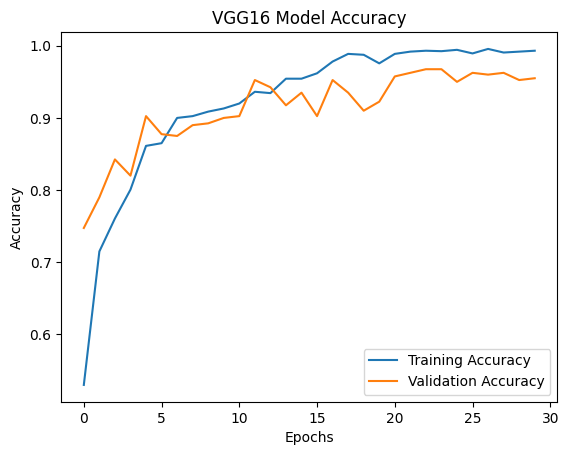

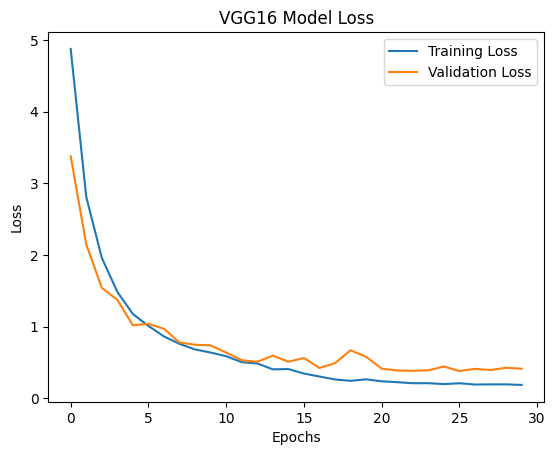

In [17]:
# Plot training and validation accuracy
plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.title("VGG16 Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.title("VGG16 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

50/50 [==============================] - 29s 573ms/step


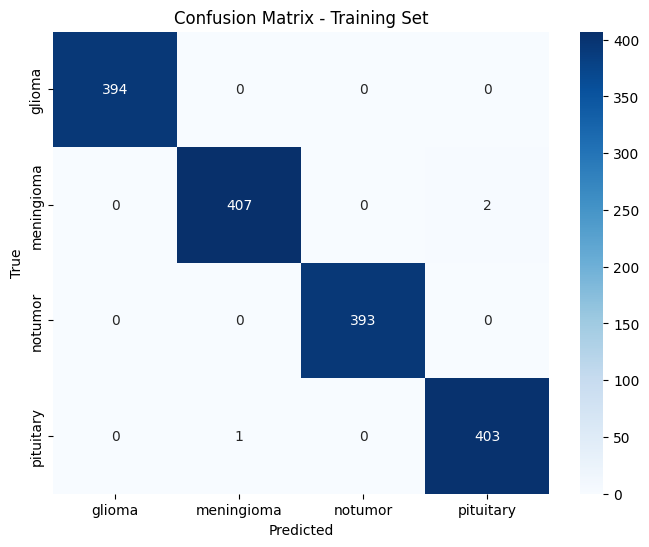

In [18]:
# Get predictions for the training set
y_pred_train = np.argmax(vgg_model.predict(x_train_final), axis=1)
y_true_train = np.argmax(y_train_final, axis=1)

# Generate the confusion matrix
cm_train = confusion_matrix(y_true_train, y_pred_train)

# Plot confusion matrix for the training set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

41/41 [==============================] - 23s 567ms/step

Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.90      0.95       300
  meningioma       0.94      0.90      0.92       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.89      1.00      0.94       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



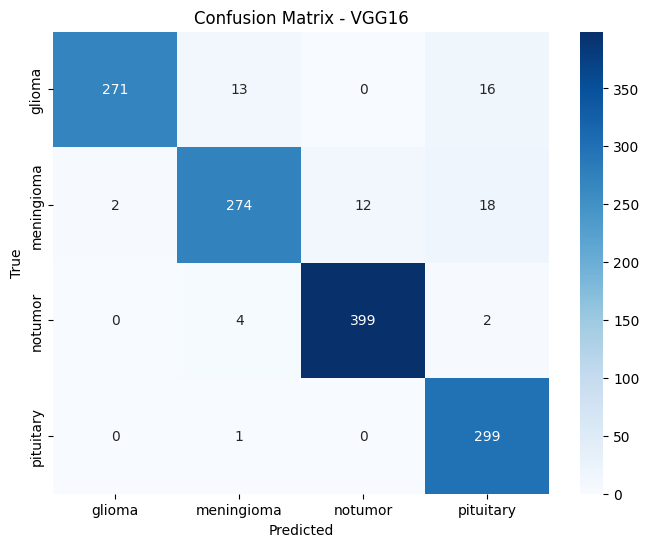

In [19]:
# Predictions
y_pred_vgg = np.argmax(vgg_model.predict(x_test), axis=1)
y_true = np.argmax(y_test_classification, axis=1)

# Classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred_vgg, target_names=labels))

# Confusion matrix
cm_vgg = confusion_matrix(y_true, y_pred_vgg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - VGG16")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


41/41 [==============================] - 23s 569ms/step


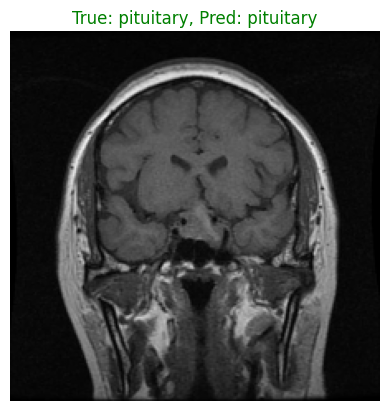

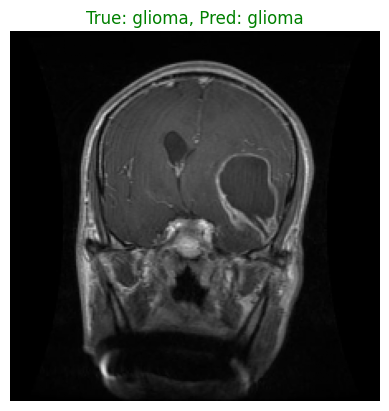

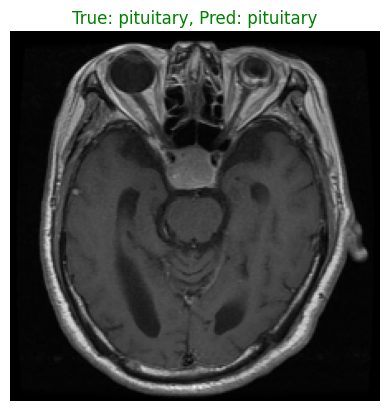

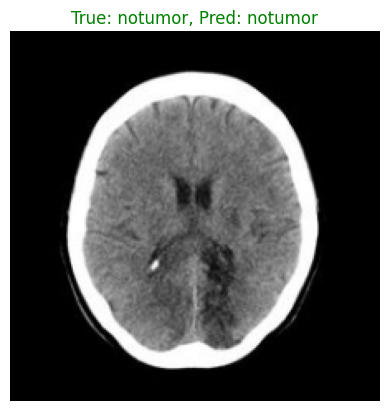

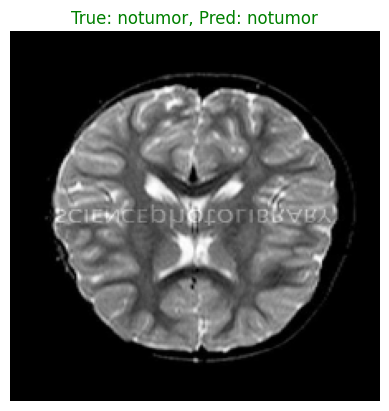

In [20]:
y_pred = np.argmax(vgg_model.predict(x_test), axis=1)  # Get class indices for predictions
for i in range(5):  # Display 5 random images
    idx = random.randint(0, len(x_test) - 1)  # Select a random index
    plt.imshow(x_test[idx])  # Display the corresponding image
    true_label = labels[np.argmax(y_test_classification[idx])]  # True label
    predicted_label = labels[y_pred[idx]]  # Predicted label
    color = 'green' if true_label == predicted_label else 'red'  # Highlight correct/incorrect
    plt.title(f"True: {true_label}, Pred: {predicted_label}", color=color)
    plt.axis('off')  # Hide axes
    plt.show()  # Display the image


In [21]:
import os
import random
from tensorflow.keras.utils import load_img, img_to_array

# Define the dataset path and classes
base_path = '/content/drive/MyDrive/project/brain tumor'
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
data_folders = ['Training', 'Testing']  # Choose whether to use Training or Testing images

# Function to fetch random images from each class
def fetch_images(base_path, data_folder, class_labels, num_samples=3):
    images_by_class = {}
    for label in class_labels:
        folder_path = os.path.join(base_path, data_folder, label)
        all_files = os.listdir(folder_path)
        sampled_files = random.sample(all_files, min(len(all_files), num_samples))  # Randomly sample
        images_by_class[label] = [os.path.join(folder_path, f) for f in sampled_files]
    return images_by_class

# Fetch images dynamically
sample_image_paths = fetch_images(base_path, 'Testing', class_labels)

# Print selected images for verification
for label, paths in sample_image_paths.items():
    print(f"Class: {label}")
    for path in paths:
        print(f"  {path}")

Class: glioma
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0270.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0232.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0238.jpg
Class: meningioma
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0059.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0113.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0218.jpg
Class: notumor
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-noTr_0002.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0183.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0153.jpg
Class: pituitary
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0104.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0290.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0046.jpg


In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_gradcam(img_path, model, layer_name, class_labels):
    """
    Generate and display Grad-CAM heatmaps for an input image.
    """
    from tensorflow.keras.models import Model
    import tensorflow as tf

    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values

    # Create a model that outputs the activations of the target layer
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Get the class index with the highest predicted probability
    preds = model.predict(img_array)
    pred_class_idx = np.argmax(preds[0])

    # Compute the gradient of the predicted class with respect to the activations
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = grads[0]
    conv_outputs = conv_outputs[0]

    # Compute the Grad-CAM heatmap
    weights = np.mean(guided_grads, axis=(0, 1))
    heatmap = np.dot(conv_outputs, weights)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize heatmap to match the image size
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert heatmap to RGB format
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap onto the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match Grad-CAM heatmap
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the image
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM - Predicted: {class_labels[pred_class_idx]}")
    plt.axis('off')
    plt.show()


Generating Grad-CAM for class: glioma

1/1 [==============================] - 0s 74ms/step


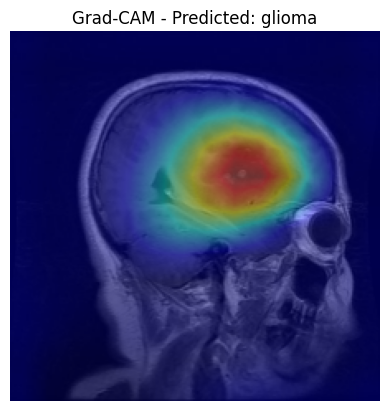

1/1 [==============================] - 0s 72ms/step


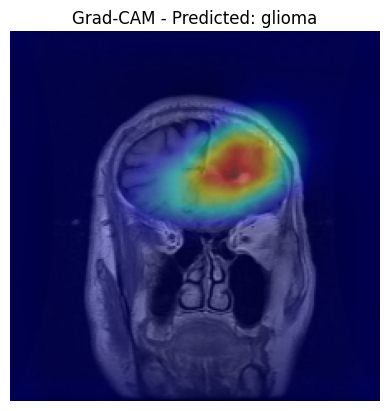

1/1 [==============================] - 0s 72ms/step


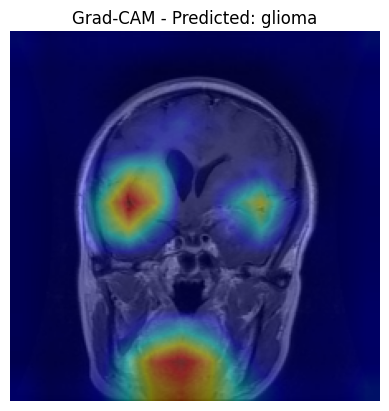


Generating Grad-CAM for class: meningioma

1/1 [==============================] - 0s 70ms/step


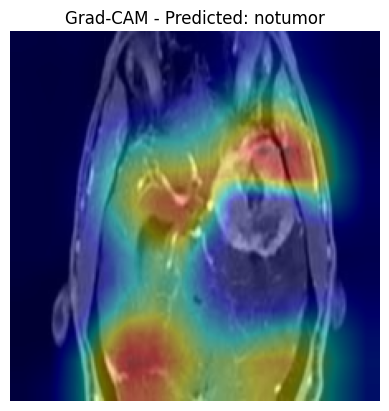

1/1 [==============================] - 0s 71ms/step


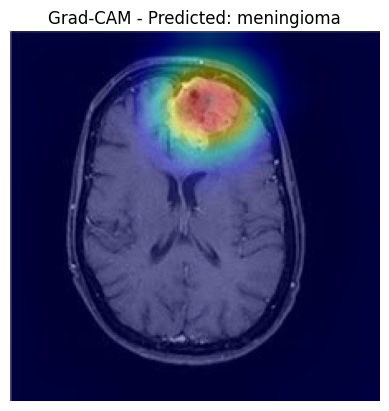

1/1 [==============================] - 0s 78ms/step


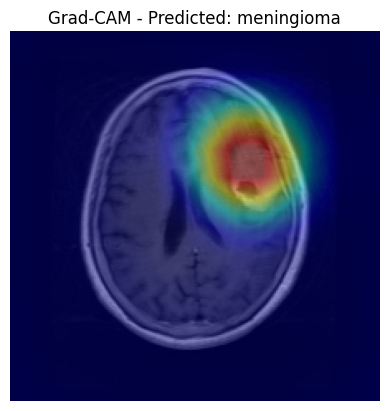


Generating Grad-CAM for class: notumor

1/1 [==============================] - 0s 70ms/step


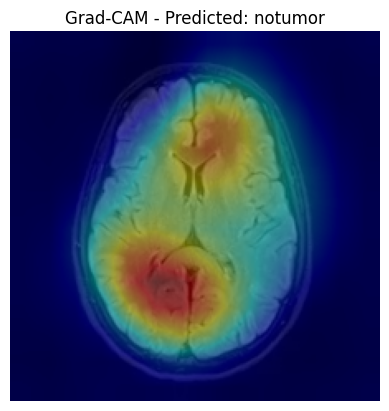

1/1 [==============================] - 0s 70ms/step


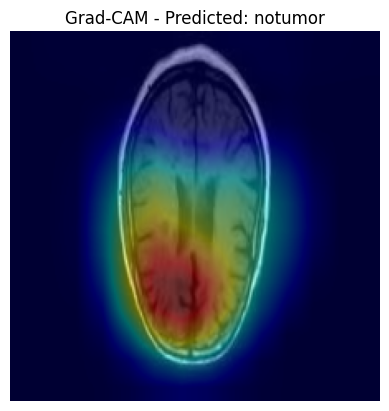

1/1 [==============================] - 0s 71ms/step


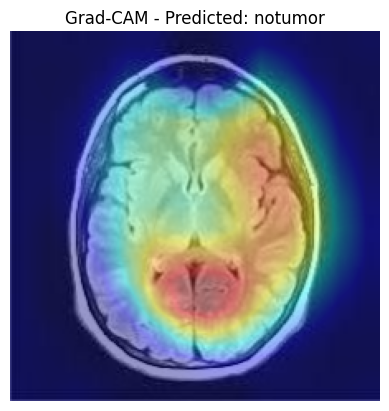


Generating Grad-CAM for class: pituitary

1/1 [==============================] - 0s 74ms/step


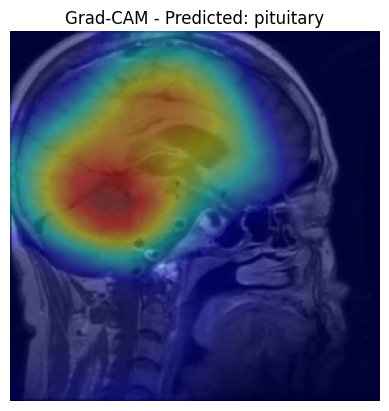

1/1 [==============================] - 0s 80ms/step


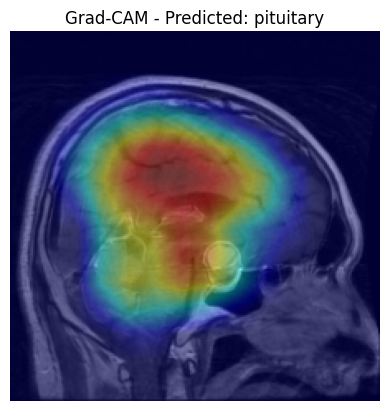

1/1 [==============================] - 0s 71ms/step


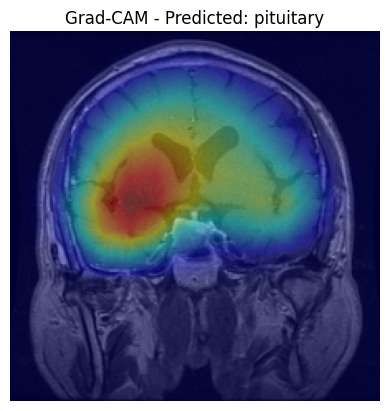

In [23]:
for label, paths in sample_image_paths.items():
    print(f"\nGenerating Grad-CAM for class: {label}\n")
    for img_path in paths:
        visualize_gradcam(img_path, vgg_model, layer_name='block5_conv3', class_labels=class_labels)

In [24]:
# Save the model
vgg_model.save('vgg16_model.h5')

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('vgg16_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train_final, axis=1)),
    y=np.argmax(y_train_final, axis=1)
)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)


Class Weights: {0: 1.015228426395939, 1: 0.9779951100244498, 2: 1.0178117048346056, 3: 0.9900990099009901}


In [27]:
# Initialize data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply data augmentation on the training set
datagen.fit(x_train_final)

In [28]:
# Load the ResNet50 model (pre-trained on ImageNet)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune the last few layers
for layer in base_model.layers[:-20]:  # Freeze all layers except the last 20
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
output = Dense(4, activation='softmax')(x)  # 4 classes (glioma, meningioma, notumor, pituitary)

# Define the model
resnet_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


In [29]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_resnet50_model.h5', monitor='val_loss', save_best_only=True)
]



In [30]:
# Train the model
history_resnet = resnet_model.fit(
    datagen.flow(x_train_final, y_train_final, batch_size=32),
    validation_data=(x_val, y_val),
    epochs=40,
    callbacks=callbacks
)

Epoch 1/40
50/50 [==============================] - ETA: 0s - loss: 5.2178 - accuracy: 0.4350

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 51s 940ms/step - loss: 5.2178 - accuracy: 0.4350 - val_loss: 4.1398 - val_accuracy: 0.2350 - lr: 1.0000e-04
Epoch 2/40
50/50 [==============================] - 45s 904ms/step - loss: 3.3305 - accuracy: 0.4669 - val_loss: 3.3399 - val_accuracy: 0.2325 - lr: 1.0000e-04
Epoch 3/40
50/50 [==============================] - 45s 904ms/step - loss: 2.8469 - accuracy: 0.5006 - val_loss: 2.9561 - val_accuracy: 0.2525 - lr: 1.0000e-04
Epoch 4/40
50/50 [==============================] - 46s 914ms/step - loss: 2.5406 - accuracy: 0.5150 - val_loss: 2.6416 - val_accuracy: 0.2950 - lr: 1.0000e-04
Epoch 5/40
50/50 [==============================] - 45s 899ms/step - loss: 2.3105 - accuracy: 0.5213 - val_loss: 2.4140 - val_accuracy: 0.4025 - lr: 1.0000e-04
Epoch 6/40
50/50 [==============================] - 45s 900ms/step - loss: 2.1389 - accuracy: 0.5288 - val_loss: 2.2386 - val_accuracy: 0.3225 - lr: 1.0000e-04
Epoch 7/40
50/50 [==============================] -

In [31]:

# Evaluate the model
test_loss, test_accuracy = resnet_model.evaluate(x_test, y_test_classification)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



41/41 [==============================] - 21s 516ms/step - loss: 0.8777 - accuracy: 0.7033
Test Loss: 0.8777462840080261
Test Accuracy: 0.7032799124717712


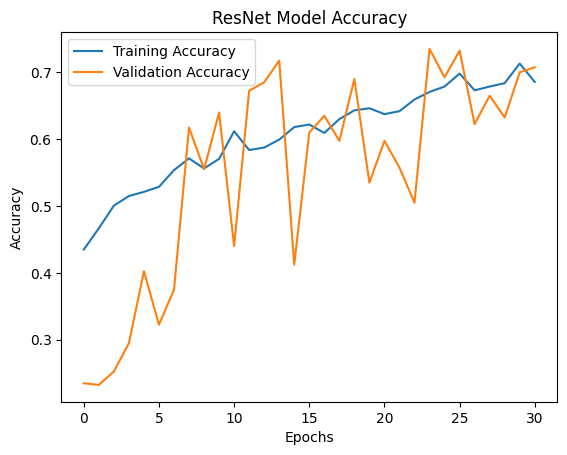

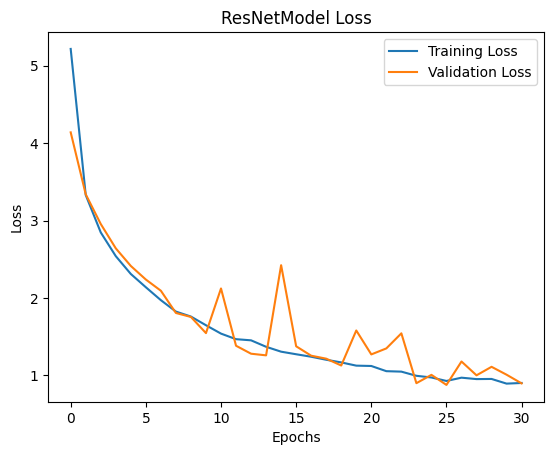

In [32]:
# Plot training and validation accuracy for ResNet50
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title("ResNet Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot training and validation loss for ResNet50
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title("ResNetModel Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


50/50 [==============================] - 29s 532ms/step


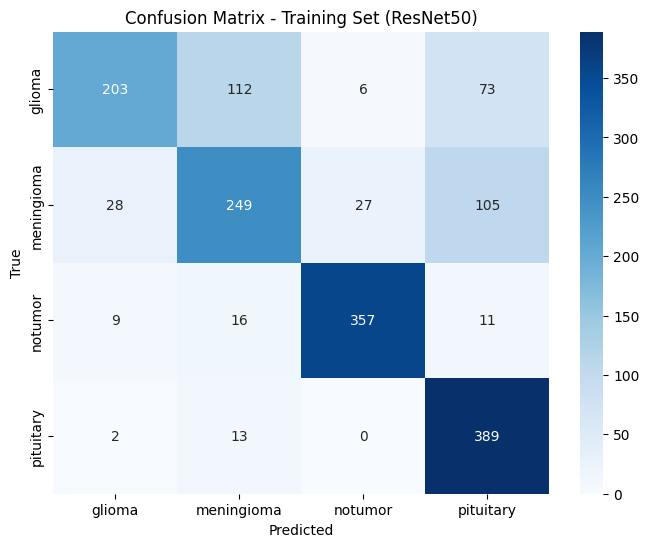

In [33]:
# Get predictions for the training set
y_pred_train_resnet = np.argmax(resnet_model.predict(x_train_final), axis=1)
y_true_train_resnet = np.argmax(y_train_final, axis=1)

# Generate the confusion matrix for ResNet50
cm_train_resnet = confusion_matrix(y_true_train_resnet, y_pred_train_resnet)

# Plot confusion matrix for the training set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Training Set (ResNet50)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


41/41 [==============================] - 23s 527ms/step

Classification Report - ResNet50:
               precision    recall  f1-score   support

      glioma       0.79      0.40      0.53       300
  meningioma       0.52      0.45      0.48       306
     notumor       0.82      0.92      0.86       405
   pituitary       0.67      0.97      0.79       300

    accuracy                           0.70      1311
   macro avg       0.70      0.69      0.67      1311
weighted avg       0.71      0.70      0.68      1311



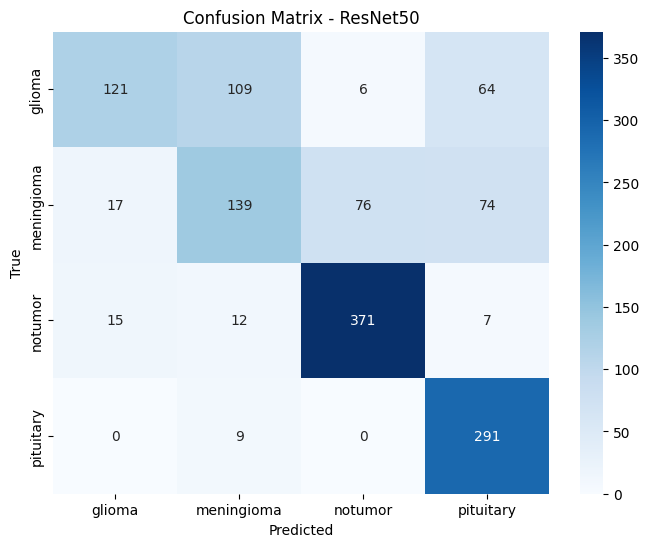

In [34]:
# Predictions for ResNet50
y_pred_resnet = np.argmax(resnet_model.predict(x_test), axis=1)
y_true_resnet = np.argmax(y_test_classification, axis=1)

# Classification report for ResNet50
print("\nClassification Report - ResNet50:\n", classification_report(y_true_resnet, y_pred_resnet, target_names=labels))

# Confusion matrix for ResNet50
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - ResNet50")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


41/41 [==============================] - 22s 524ms/step


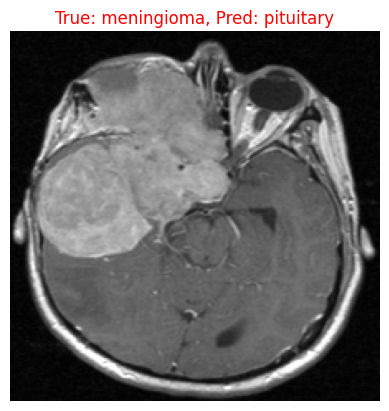

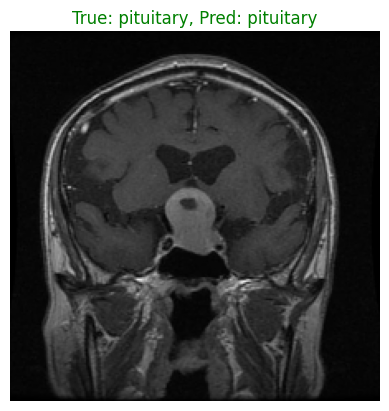

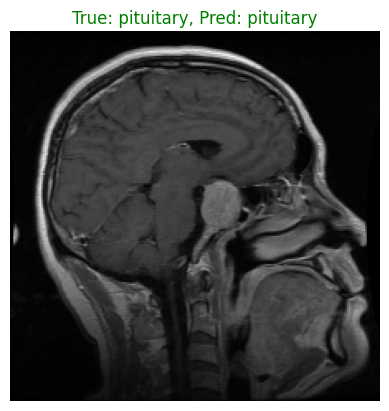

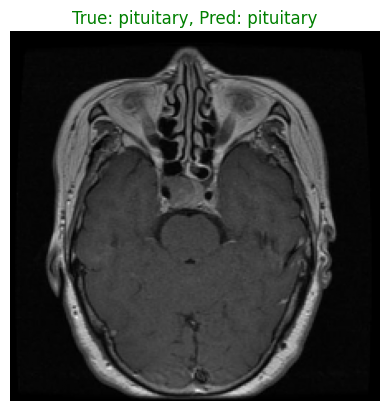

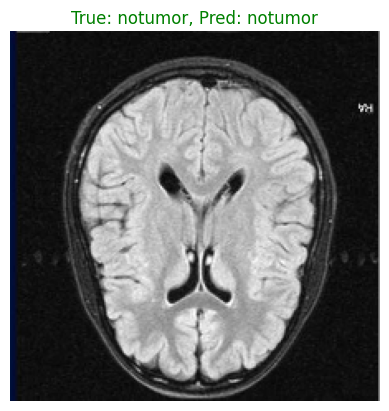

In [35]:
# Get predictions for the test set
resnet_predictions = np.argmax(resnet_model.predict(x_test), axis=1)  # Predictions for x_test

# Display 5 random images with true and predicted labels
for i in range(5):
    idx = random.randint(0, len(x_test) - 1)  # Select a random index
    plt.imshow(x_test[idx])  # Display the image
    true_label = labels[np.argmax(y_test_classification[idx])]  # True label
    predicted_label = labels[resnet_predictions[idx]]  # Predicted label
    color = 'green' if true_label == predicted_label else 'red'  # Correct = green, Incorrect = red
    plt.title(f"True: {true_label}, Pred: {predicted_label}", color=color)
    plt.axis('off')  # Hide axes
    plt.show()  # Display the image


Class: glioma
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-glTr_0000.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0040.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0118.jpg
Class: meningioma
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0210.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0010.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0186.jpg
Class: notumor
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0155.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0094.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0244.jpg
Class: pituitary
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0092.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0290.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0160.jpg

Generatin

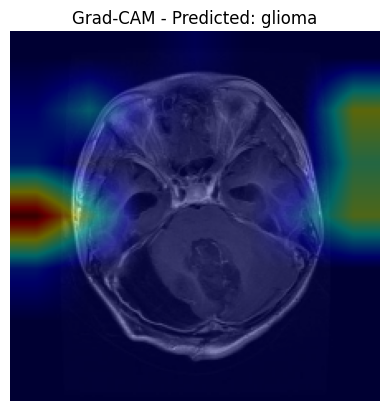

1/1 [==============================] - 0s 91ms/step


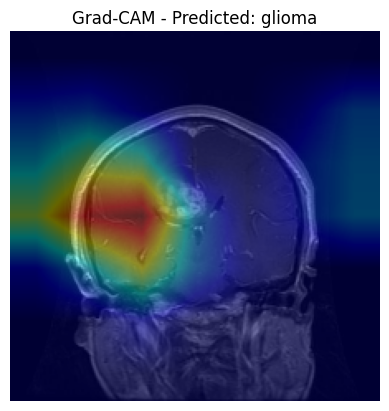

1/1 [==============================] - 0s 91ms/step


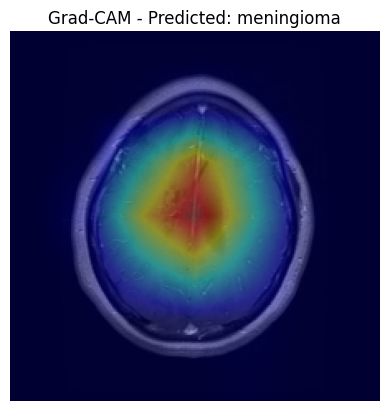


Generating Grad-CAM for class: meningioma

1/1 [==============================] - 0s 86ms/step


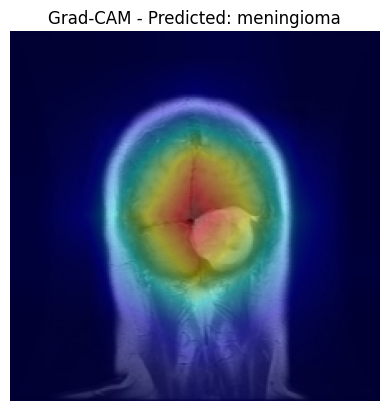

1/1 [==============================] - 0s 90ms/step


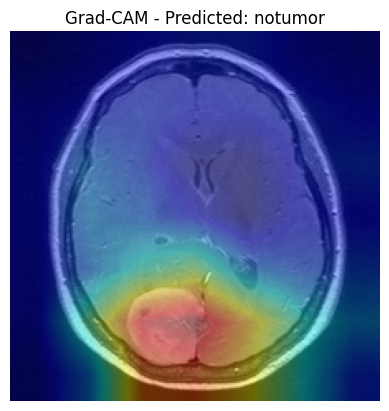

1/1 [==============================] - 0s 89ms/step


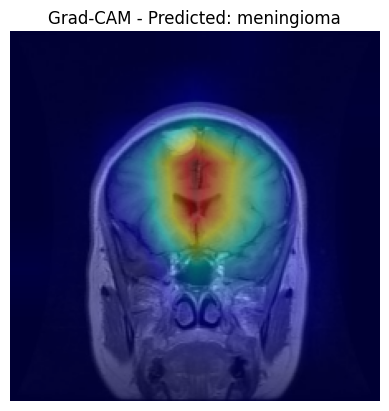


Generating Grad-CAM for class: notumor

1/1 [==============================] - 0s 86ms/step


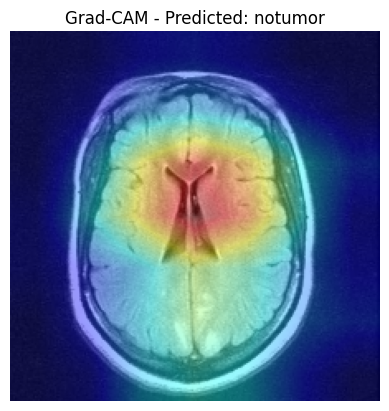

1/1 [==============================] - 0s 88ms/step


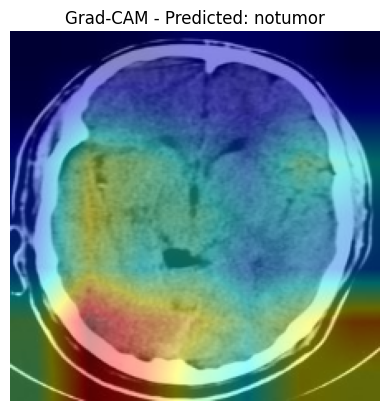

1/1 [==============================] - 0s 89ms/step


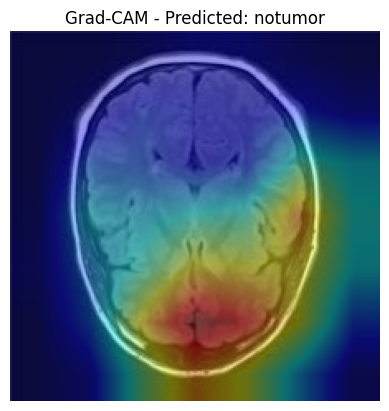


Generating Grad-CAM for class: pituitary

1/1 [==============================] - 0s 89ms/step


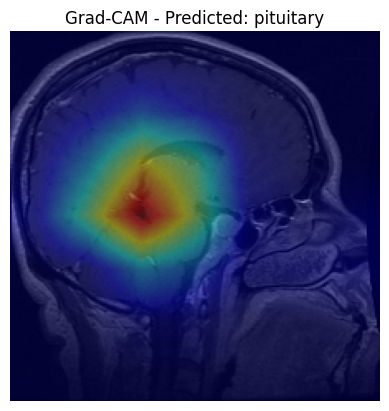

1/1 [==============================] - 0s 86ms/step


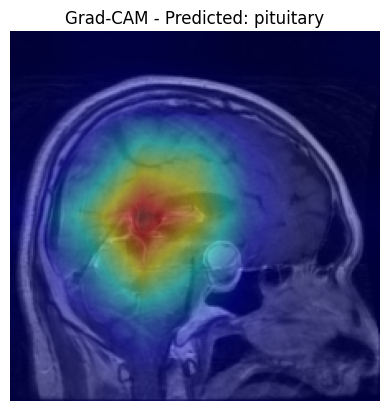

1/1 [==============================] - 0s 96ms/step


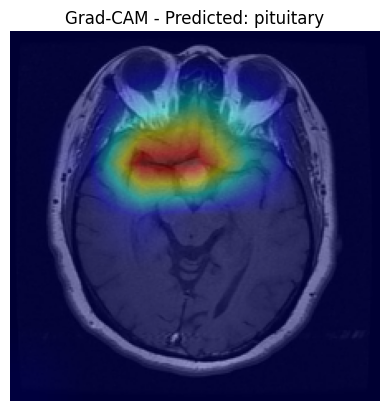

In [40]:

import os
import random
from tensorflow.keras.utils import load_img, img_to_array

# Define the dataset path and classes
base_path = '/content/drive/MyDrive/project/brain tumor'
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
data_folders = ['Training', 'Testing']  # Choose whether to use Training or Testing images

# Function to fetch random images from each class
def fetch_images(base_path, data_folder, class_labels, num_samples=3):
    images_by_class = {}
    for label in class_labels:
        folder_path = os.path.join(base_path, data_folder, label)
        all_files = os.listdir(folder_path)
        sampled_files = random.sample(all_files, min(len(all_files), num_samples))  # Randomly sample
        images_by_class[label] = [os.path.join(folder_path, f) for f in sampled_files]
    return images_by_class

# Fetch images dynamically
sample_image_paths = fetch_images(base_path, 'Testing', class_labels)

# Print selected images for verification
for label, paths in sample_image_paths.items():
    print(f"Class: {label}")
    for path in paths:
        print(f"  {path}")

import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_gradcam_resnet(img_path, model, layer_name, class_labels):
    """
    Generate and display Grad-CAM heatmaps for an input image for ResNet50.
    """
    from tensorflow.keras.models import Model
    import tensorflow as tf

    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values

    # Create a model that outputs the activations of the target layer
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Get the class index with the highest predicted probability
    preds = model.predict(img_array)
    pred_class_idx = np.argmax(preds[0])

    # Compute the gradient of the predicted class with respect to the activations
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = grads[0]
    conv_outputs = conv_outputs[0]

    # Compute the Grad-CAM heatmap
    weights = np.mean(guided_grads, axis=(0, 1))
    heatmap = np.dot(conv_outputs, weights)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize heatmap to match the image size
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert heatmap to RGB format
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap onto the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match Grad-CAM heatmap
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the image
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM - Predicted: {class_labels[pred_class_idx]}")
    plt.axis('off')
    plt.show()

# Specify the last convolutional layer in ResNet50
layer_name = 'conv5_block3_out'  # Adjust based on your ResNet50 architecture

# Generate Grad-CAM for each class
for label, paths in sample_image_paths.items():
    print(f"\nGenerating Grad-CAM for class: {label}\n")
    for img_path in paths:
        visualize_gradcam_resnet(img_path, resnet_model, layer_name, class_labels=class_labels)


In [41]:
# Save the model
resnet_model.save('resnet_model.h5')

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('resnet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_classification.argmax(axis=1)),
    y=y_train_classification.argmax(axis=1)
)
class_weights = dict(enumerate(class_weights))

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
def create_custom_cnn(input_shape, num_classes):
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Block
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))  # Dropout for regularization
    model.add(Dense(num_classes, activation='softmax'))  # Final layer for classification

    return model

input_shape = (224, 224, 3)  # Input size (adjust based on your dataset)
num_classes = 4  # Number of tumor classes

custom_cnn = create_custom_cnn(input_shape, num_classes)

custom_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

custom_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 128)     512       
 chNormalization)                                                
                                                        

In [44]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint('best_custom_cnn.h5', monitor='val_loss', save_best_only=True, mode='min')
]

In [45]:
history_custom_cnn = custom_cnn.fit(
    datagen.flow(x_train, y_train_classification, batch_size=32),
    validation_data=(x_val, y_val),
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 2.7288 - accuracy: 0.4775 - precision_1: 0.5199 - recall_1: 0.3910

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 99s 2s/step - loss: 2.7288 - accuracy: 0.4775 - precision_1: 0.5199 - recall_1: 0.3910 - val_loss: 19.4203 - val_accuracy: 0.2650 - val_precision_1: 0.2650 - val_recall_1: 0.2650 - lr: 1.0000e-04
Epoch 2/30
63/63 [==============================] - 95s 1s/step - loss: 1.1610 - accuracy: 0.5420 - precision_1: 0.6343 - recall_1: 0.3860 - val_loss: 26.7583 - val_accuracy: 0.2650 - val_precision_1: 0.2650 - val_recall_1: 0.2650 - lr: 1.0000e-04
Epoch 3/30
63/63 [==============================] - 94s 1s/step - loss: 1.0584 - accuracy: 0.5650 - precision_1: 0.6915 - recall_1: 0.3855 - val_loss: 25.8042 - val_accuracy: 0.2650 - val_precision_1: 0.2650 - val_recall_1: 0.2650 - lr: 1.0000e-04
Epoch 4/30
63/63 [==============================] - 95s 2s/step - loss: 1.0007 - accuracy: 0.5935 - precision_1: 0.7086 - recall_1: 0.4255 - val_loss: 14.5277 - val_accuracy: 0.2650 - val_precision_1: 0.2650 - val_recall_1: 0.2650 - lr: 1.0000e-04
Epoch 5/30
63/63 [=

In [46]:

test_loss, test_accuracy, test_precision, test_recall = custom_cnn.evaluate(x_test, y_test_classification)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

41/41 [==============================] - 13s 306ms/step - loss: 0.6136 - accuracy: 0.7643 - precision_1: 0.8069 - recall_1: 0.7109
Test Loss: 0.6135861277580261
Test Accuracy: 0.7643020749092102
Test Precision: 0.806926429271698
Test Recall: 0.7109076976776123


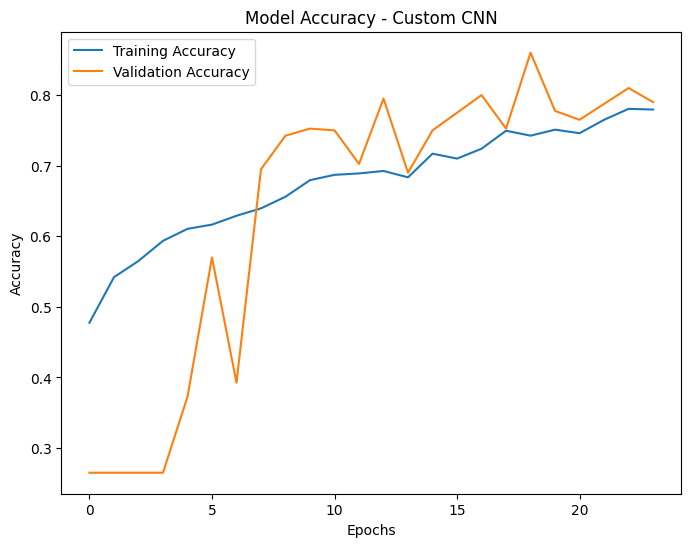

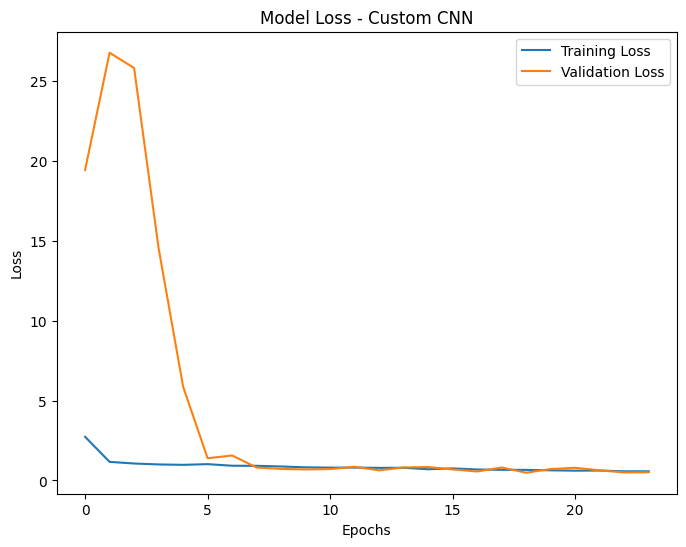

In [47]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history_custom_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_custom_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy - Custom CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history_custom_cnn.history['loss'], label='Training Loss')
plt.plot(history_custom_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss - Custom CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

50/50 [==============================] - 15s 297ms/step


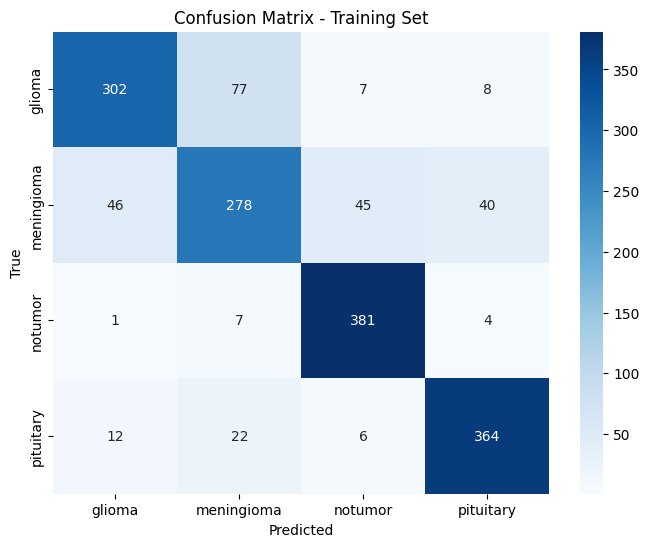

In [48]:
# Get predictions for the training set
y_train_pred = custom_cnn.predict(x_train_final)
y_train_pred_classes = y_train_pred.argmax(axis=1)
y_train_true_classes = y_train_final.argmax(axis=1)

# Generate the confusion matrix
cm_train = confusion_matrix(y_train_true_classes, y_train_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

41/41 [==============================] - 12s 298ms/step
              precision    recall  f1-score   support

      glioma       0.81      0.62      0.70       300
  meningioma       0.60      0.50      0.55       306
    no tumor       0.79      0.97      0.87       405
   pituitary       0.83      0.89      0.86       300

    accuracy                           0.76      1311
   macro avg       0.76      0.75      0.74      1311
weighted avg       0.76      0.76      0.75      1311



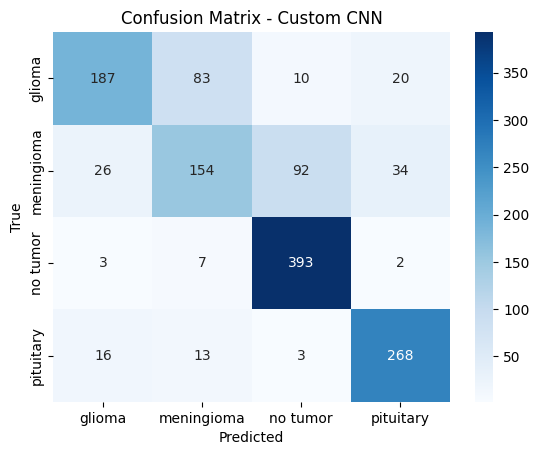

In [49]:

y_pred_test = np.argmax(custom_cnn.predict(x_test), axis=1)
y_true_test = np.argmax(y_test_classification, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_true_test, y_pred_test, target_names=['glioma', 'meningioma', 'no tumor', 'pituitary']))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'],
            yticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'])
plt.title('Confusion Matrix - Custom CNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Class: glioma
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0036.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0263.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/glioma/Te-gl_0185.jpg
Class: meningioma
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0264.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0230.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/meningioma/Te-me_0047.jpg
Class: notumor
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0368.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0372.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/notumor/Te-no_0376.jpg
Class: pituitary
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0011.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0167.jpg
  /content/drive/MyDrive/project/brain tumor/Testing/pituitary/Te-pi_0262.jpg

Generating 

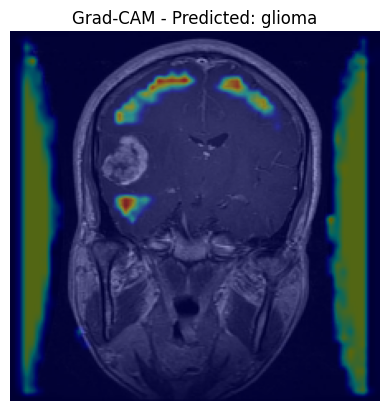

1/1 [==============================] - 0s 60ms/step


<ipython-input-50-6f211a0231ad>:71: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
<ipython-input-50-6f211a0231ad>:77: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


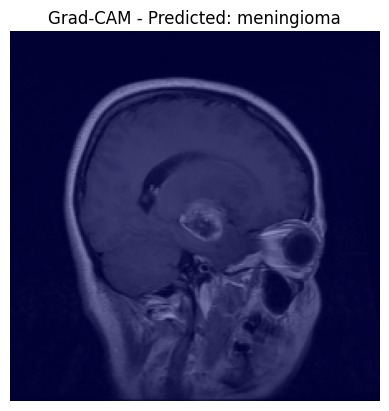

1/1 [==============================] - 0s 65ms/step


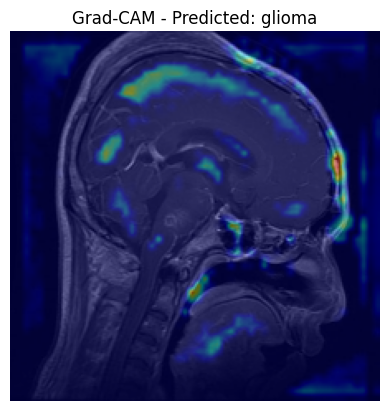


Generating Grad-CAM for class: meningioma

1/1 [==============================] - 0s 65ms/step


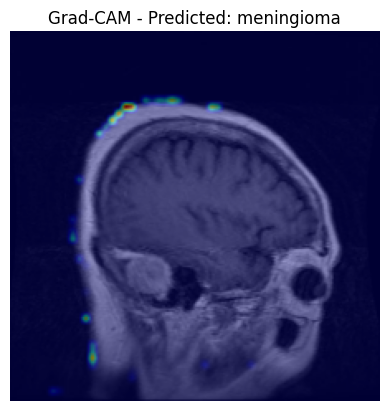

1/1 [==============================] - 0s 61ms/step


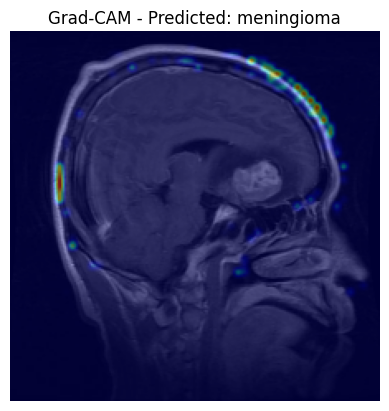

1/1 [==============================] - 0s 65ms/step


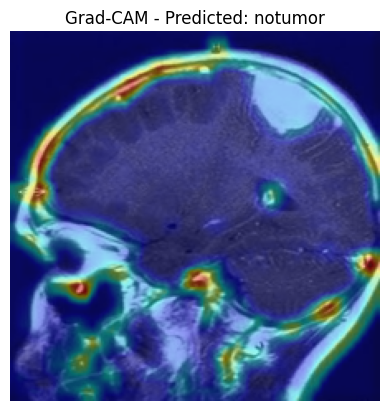


Generating Grad-CAM for class: notumor

1/1 [==============================] - 0s 64ms/step


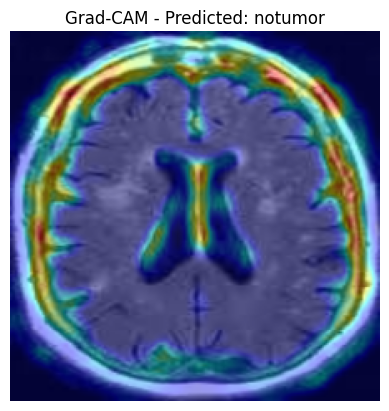

1/1 [==============================] - 0s 70ms/step


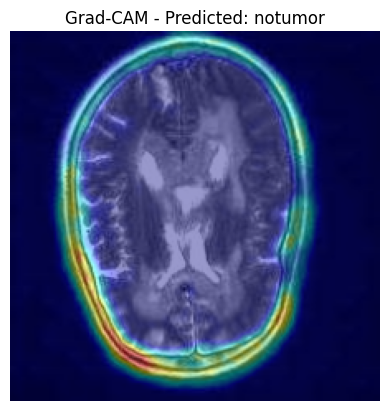

1/1 [==============================] - 0s 63ms/step


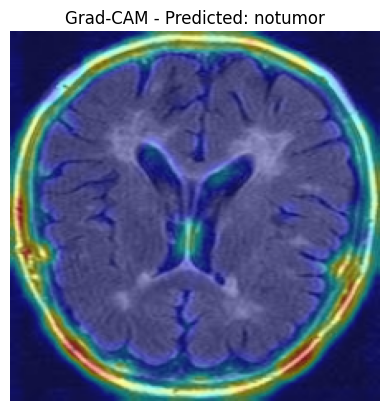


Generating Grad-CAM for class: pituitary

1/1 [==============================] - 0s 61ms/step


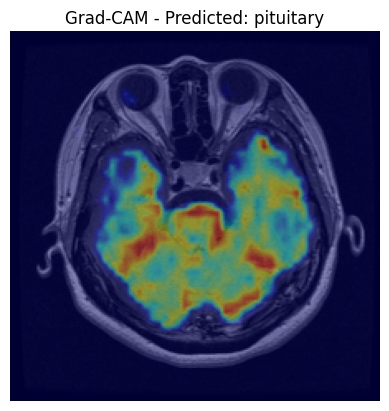

1/1 [==============================] - 0s 67ms/step


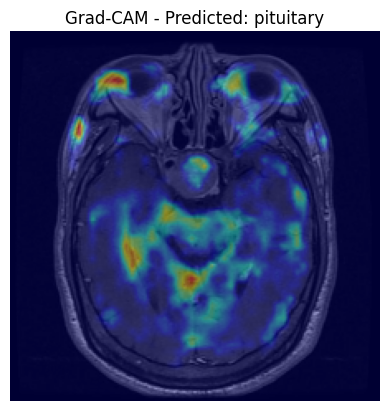

1/1 [==============================] - 0s 63ms/step


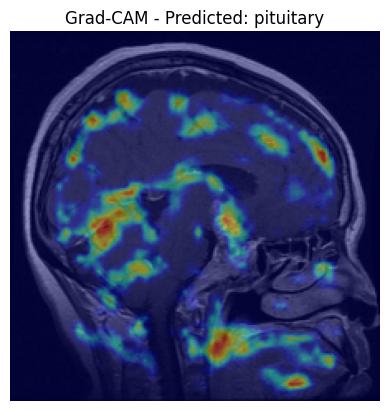

In [50]:
import os
import random
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Model
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the dataset path and classes
base_path = '/content/drive/MyDrive/project/brain tumor'
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
data_folders = ['Training', 'Testing']  # Choose whether to use Training or Testing images

# Function to fetch random images from each class
def fetch_images(base_path, data_folder, class_labels, num_samples=3):
    images_by_class = {}
    for label in class_labels:
        folder_path = os.path.join(base_path, data_folder, label)
        all_files = os.listdir(folder_path)
        sampled_files = random.sample(all_files, min(len(all_files), num_samples))  # Randomly sample
        images_by_class[label] = [os.path.join(folder_path, f) for f in sampled_files]
    return images_by_class

# Fetch images dynamically
sample_image_paths = fetch_images(base_path, 'Testing', class_labels)

# Print selected images for verification
for label, paths in sample_image_paths.items():
    print(f"Class: {label}")
    for path in paths:
        print(f"  {path}")

# Grad-CAM function for Custom CNN
def visualize_gradcam_custom(img_path, model, layer_name, class_labels):
    """
    Generate and display Grad-CAM heatmaps for an input image for Custom CNN.
    """
    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values

    # Create a model that outputs the activations of the target layer
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Get the class index with the highest predicted probability
    preds = model.predict(img_array)
    pred_class_idx = np.argmax(preds[0])

    # Compute the gradient of the predicted class with respect to the activations
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    guided_grads = grads[0]
    conv_outputs = conv_outputs[0]

    # Compute the Grad-CAM heatmap
    weights = np.mean(guided_grads, axis=(0, 1))
    heatmap = np.dot(conv_outputs, weights)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize heatmap to match the image size
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert heatmap to RGB format
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap onto the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize image to match Grad-CAM heatmap
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Display the image
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM - Predicted: {class_labels[pred_class_idx]}")
    plt.axis('off')
    plt.show()

# Specify the last convolutional layer in your custom CNN
# Use model.summary() to identify the correct layer
layer_name = 'conv2d_2'  # Adjust this to the last convolutional layer in your custom CNN

# Generate Grad-CAM for each class
for label, paths in sample_image_paths.items():
    print(f"\nGenerating Grad-CAM for class: {label}\n")
    for img_path in paths:
        visualize_gradcam_custom(img_path, custom_cnn, layer_name, class_labels=class_labels)


In [51]:
# Save the model
custom_cnn.save('custom_cnn_model.h5')

# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('custom_cnn_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 12s 298ms/step
              precision    recall  f1-score   support

      glioma       0.97      0.87      0.92       300
  meningioma       0.89      0.75      0.81       306
     notumor       0.89      0.99      0.94       405
   pituitary       0.88      1.00      0.93       300

    accuracy                           0.91      1311
   macro avg       0.91      0.90      0.90      1311
weighted avg       0.91      0.91      0.90      1311



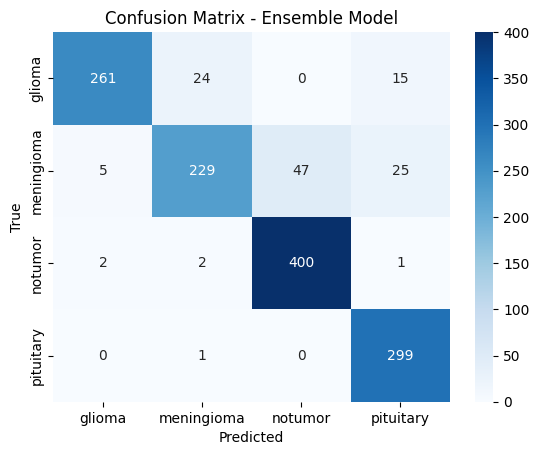

In [52]:
# Get predicted probabilities for each model
vgg_probs = vgg_model.predict(x_test)
resnet_probs = resnet_model.predict(x_test)
custom_probs = custom_cnn.predict(x_test)

# Average the probabilities
ensemble_probs = (vgg_probs + resnet_probs + custom_probs) / 3

# Get the final predictions
ensemble_preds = np.argmax(ensemble_probs, axis=1)

# Evaluate performance
print(classification_report(np.argmax(y_test_classification, axis=1), ensemble_preds, target_names=labels))
cm = confusion_matrix(np.argmax(y_test_classification, axis=1), ensemble_preds)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Assuming `ensemble_preds` are your ensemble model's predictions
y_true = np.argmax(y_test_classification, axis=1)  # True labels (one-hot encoded)

# Calculate metrics
accuracy = accuracy_score(y_true, ensemble_preds)
precision = precision_score(y_true, ensemble_preds, average='weighted')
recall = recall_score(y_true, ensemble_preds, average='weighted')
f1 = f1_score(y_true, ensemble_preds, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


Accuracy: 0.9069412662090007
Precision: 0.9093290453080035
Recall: 0.9069412662090007
F1-Score: 0.9044028077600188


41/41 [==============================] - 12s 293ms/step
                        Model  Accuracy  Precision    Recall  F1-Score
0                       VGG16  0.948131   0.950325  0.948131  0.947956
1                    ResNet50  0.703280   0.707317  0.703280  0.683205
2                  Custom CNN  0.764302   0.757383  0.764302  0.754022
3  Ensemble (Majority Voting)  0.840580   0.839648  0.840580  0.833715


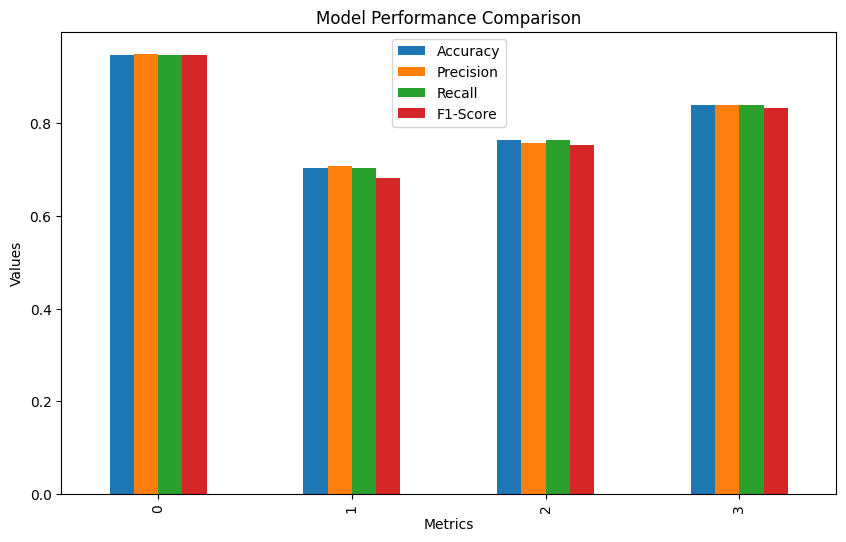

In [54]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

# Get predictions for each individual model
vgg_preds = np.argmax(vgg_model.predict(x_test), axis=1)
resnet_preds = np.argmax(resnet_model.predict(x_test), axis=1)
custom_preds = np.argmax(custom_cnn.predict(x_test), axis=1)

# True labels
y_true = np.argmax(y_test_classification, axis=1)

# Ensemble model predictions (majority voting)
ensemble_preds = []
for i in range(len(vgg_preds)):
    preds = [vgg_preds[i], resnet_preds[i], custom_preds[i]]
    ensemble_preds.append(max(set(preds), key=preds.count))

# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {"Model": model_name, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1}

# Evaluate all models
results = []
results.append(evaluate_model(y_true, vgg_preds, "VGG16"))
results.append(evaluate_model(y_true, resnet_preds, "ResNet50"))
results.append(evaluate_model(y_true, custom_preds, "Custom CNN"))
results.append(evaluate_model(y_true, ensemble_preds, "Ensemble (Majority Voting)"))

# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

# Alternatively, if you want to visualize it better
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'results_df' is a DataFrame
results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.legend(loc="best")
plt.show()



